#PROGETTO DI CALCOLO NUMERICO A.A. 2021/2022

Gruppo composto da:


*   Apollonio Francesco
*   Bianchi Andrea
*   Mazzetti Francesca

# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from scipy.optimize import minimize
from numpy import fft

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512$\times$512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


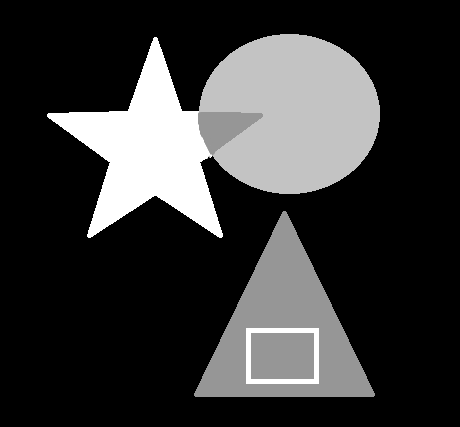


## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

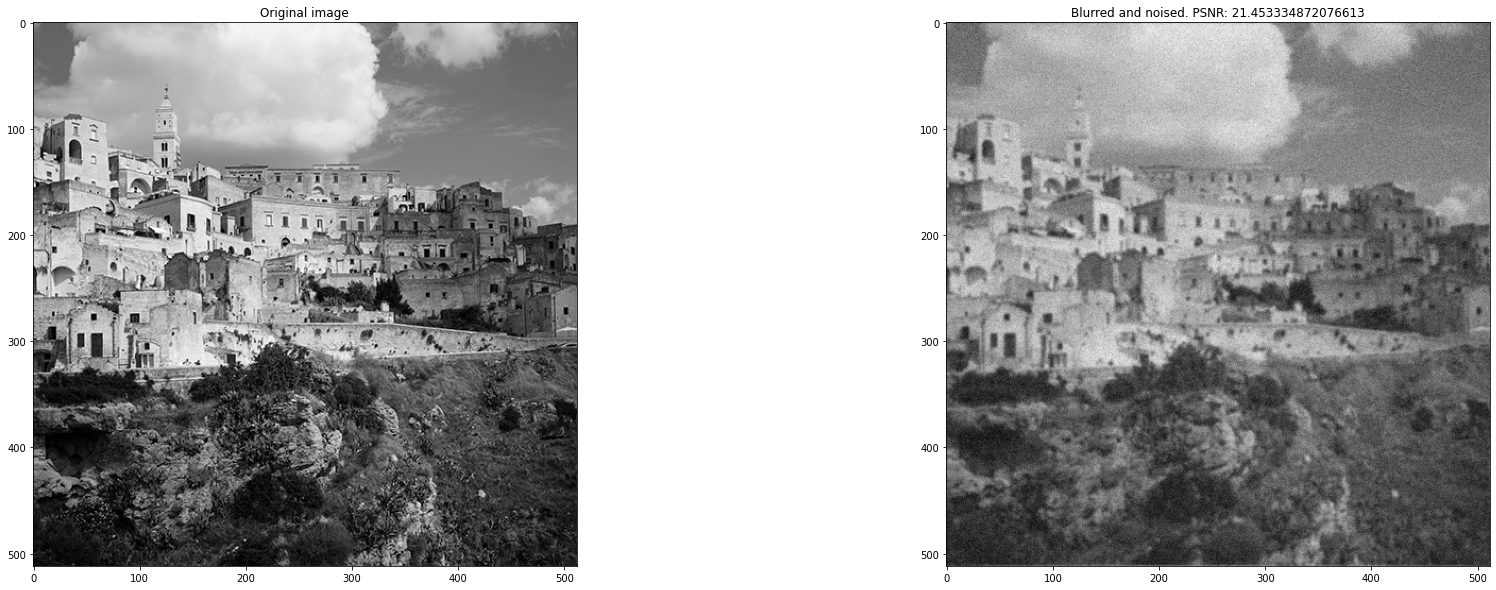

In [7]:
x0 = np.zeros((512, 512))

# Caricamento dell'immagine
img_name = 'sample10.png'
img = plt.imread(img_name).astype(np.float64)

# Generazione del filtro di blur
K1 = psf_fft(gaussian_kernel(5, 0.5), 5, x0.shape)
K2 = psf_fft(gaussian_kernel(7, 1), 7, x0.shape)
K3 = psf_fft(gaussian_kernel(9, 1.3), 9, x0.shape)

# Generazione del rumore
deviazione_standard = 0.05
noise = np.random.normal(size = x0.shape) * deviazione_standard

# Applicazione del filtro di blur K1 e del rumore
blurred = A(img, K1)
noised = blurred + noise

# Applicazione del filtro di blur K2 e del rumore
blurred_2 = A(img, K2)
noised_2 = blurred + noise

# Applicazione del filtro di blur K3 e del rumore
blurred = A(img, K3)
noised = blurred + noise

# Calcolo del PSNR per avere un'idea immediata e oggettiva del deterioramento dell'immagine
PSNR_noised = metrics.peak_signal_noise_ratio(img, noised)

#Plotting of the images
plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original image')

plt.subplot(1, 2, 2)
plt.imshow(noised, cmap='gray')
plt.title('Blurred and noised. PSNR: '+ str(PSNR_noised))

plt.show()

## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

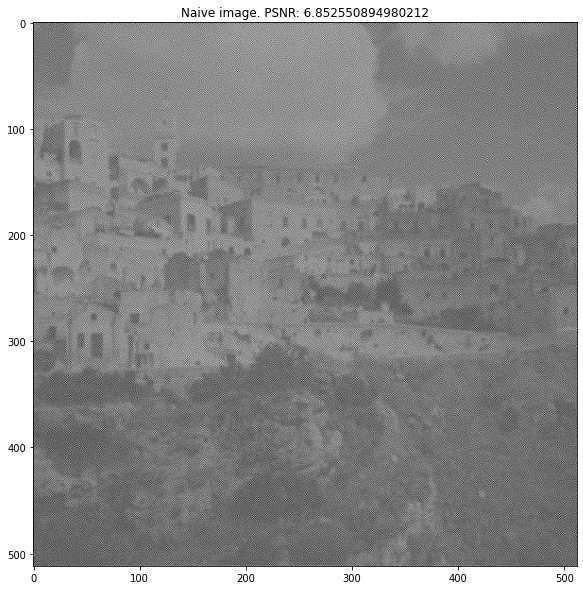

In [8]:
# N.B. 
# Per una questione di leggibiità del codice tutte le funzioni di minimizzazione sono applicate su una singola immagine blurrata con filtro K1. 
# Tutti gli altri test sono, ovviamente, stati eseguiti e riportati nella relazione allegata.

# Funzioni da minimizzare calcolando una soluzione Naive
def f_naive(x):
  X = x.reshape(512, 512)
  res = 0.5 * (np.linalg.norm(A(X, K1) - noised)) ** 2
  return res

def df_naive(x):
  X = x.reshape(512, 512)
  res = AT(A(X, K1) - noised, K1)
  res2 = np.reshape(res, 512 * 512)
  return res2

# Ricostruzione dell'immagine usando il metodo del gradiente coniugato implementato dalla funzione minimize di libreria
res = minimize(f_naive, x0, method='CG', jac=df_naive, options={'maxiter': 100})
img_naive = res.x.reshape(512, 512)

# Calcolo del PSNR per avere'idea concreta di quanto possa essere migliorata l'immagine rispetto alla sua versione 'corrotta'
# (A posteriori notiamo comunque come la versione Naive risulti essere peggiore, anche di molto, rispetto alla versione 'noised' )
PSNR_naive = metrics.peak_signal_noise_ratio(img, img_naive)

#Plotting of the images
plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_naive, cmap='gray')
plt.title('Naive image. PSNR: ' + str(PSNR_naive))

plt.show()

## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

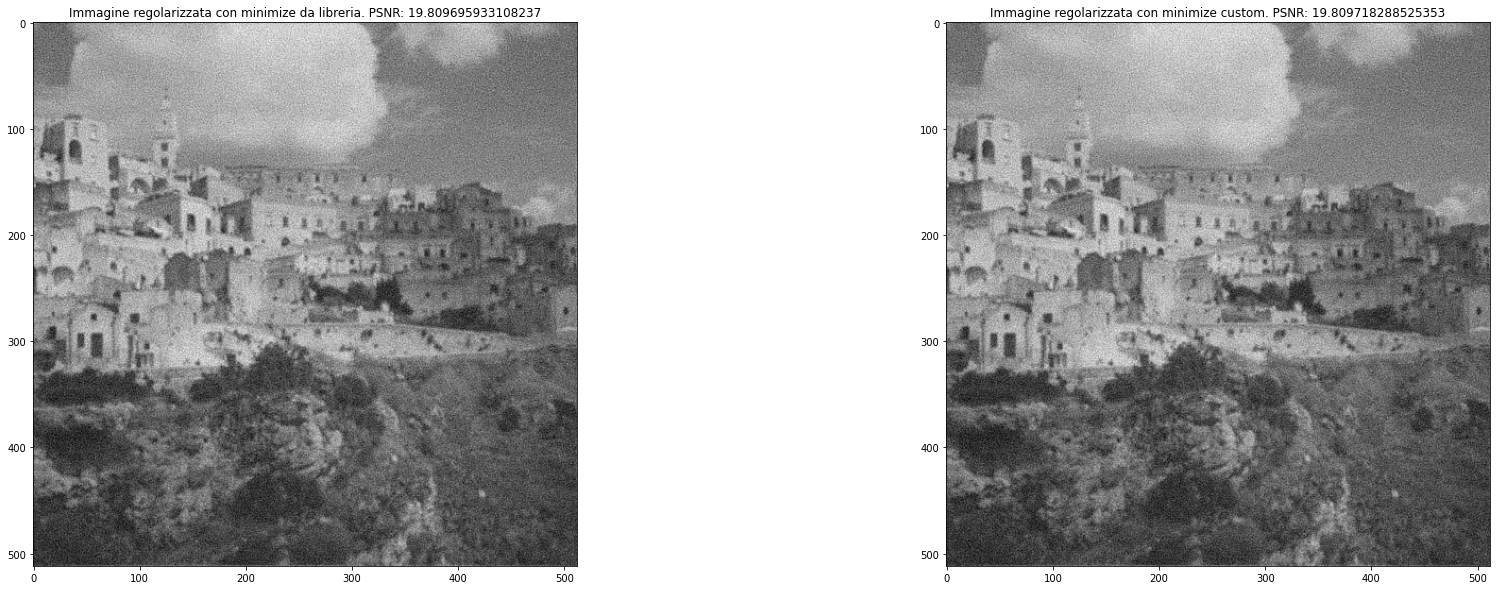

In [12]:
# Procedura di backtracking per la scelta della dimensione del passo nella funzione minimze sottostante
def next_step(x, grad, f_reg):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  p = -grad
  j = 0
  jmax = 10
  while ((f_reg(x.reshape(x.size)+alpha*p) > f_reg(x)+c1*alpha*grad.T@p) and j < jmax):
    alpha = rho*alpha
    j += 1
  if (j > jmax):
    return -1
  else:
    return alpha


# Funzione minimize implementata secondo quanto visto a lezione
def custom_minimize(x0, b, MAXITERATION, ABSOLUTE_STOP, f_reg, df_reg):
  norm_grad_list = np.zeros((1, MAXITERATION))
  function_eval_list = np.zeros((1, MAXITERATION))
  error_list = np.zeros((1, MAXITERATION))

  # inizializzazione
  x_last = np.copy(x0)

  k = 0

  function_eval_list[k] = f_reg(x_last)
  error_list[k] = np.linalg.norm(x_last - b)
  norm_grad_list[k] = np.linalg.norm(df_reg(x_last))

  while (np.linalg.norm(df_reg(x_last)) > ABSOLUTE_STOP and k < MAXITERATION - 1):
    k = k + 1
    # la direzione è data dal gradiente dell'ultima iterazione
    grad = df_reg(x_last)

    # backtracking step
    step = next_step(x_last, grad, f_reg)

    if (step == -1):
      print('non convergente')
      return (k)

    x_last = x_last - (step * grad).reshape(512, 512)

    function_eval_list[0][k] = f_reg(x_last)
    error_list[0][k] = np.linalg.norm(x_last - b)
    norm_grad_list[0][k] = np.linalg.norm(df_reg(x_last))

  function_eval_list = function_eval_list[0][:k + 1]
  error_list = error_list[0][:k + 1]
  norm_grad_list = norm_grad_list[0][:k + 1]

  return (x_last, norm_grad_list, function_eval_list, error_list, k)



# Funzioni da minimizzare con il termine di regolarizzazione di Tikhonov

# Tale valore di lambda è stato scelto dopo una serie di test che ci hanno portato a determinarne l'ottimalità.
# I risultati ottenuti con ulteriori valori di lambda sono riportati e commentati nella relazione allegata.
lambda_value = 0.08

def f_reg(x):
  X = x.reshape(512, 512)
  res = 0.5 * (np.linalg.norm(A(X, K1) - noised)) ** 2 + (lambda_value / 2) * (np.linalg.norm(X) ** 2)
  return res

def df_reg(x):
  X = x.reshape(512, 512)
  res = AT(A(X, K1) - noised, K1) + (lambda_value * X)
  res2 = np.reshape(res, 512*512)
  return res2

# Ricostruzione dell'immagine utilizzando il metodo del gradiente coniugato, la funzione minimize di libreria e il termine di regolarizzazione di Tikhonov
res = minimize(f_reg, x0, method='CG', jac=df_reg, options={'maxiter': 100})
img_reg = res.x.reshape(512, 512)

# Ricostruzione dell'immagine utilizzando utilizzando il metodo del gradiente illustrato a lezione e il termine di regolarizzazione di Tikhonov
(img_reg_2, norm_g_list, fun_eval_list, errors, iterations) = custom_minimize(x0, noised, 100, 1.e-5, f_reg, df_reg)

PSNR_reg = metrics.peak_signal_noise_ratio(img, img_reg)
PSNR_reg2 = metrics.peak_signal_noise_ratio(img, img_reg_2)


#Plotting of the images
plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_reg, cmap='gray')
plt.title('Immagine regolarizzata con minimize da libreria. PSNR: ' + str(PSNR_reg))


plt.subplot(1, 2, 2)
plt.imshow(img_reg_2, cmap='gray')
plt.title('Immagine regolarizzata con minimize custom. PSNR: ' + str(PSNR_reg2))

plt.show()

## 4) Variazione Totale (Facoltativo) 

Un altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [13]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

Text(0.5, 1.0, 'Immagine regolarizzata con la funzione di "Variazione totale". PSNR: 21.64853260165049')

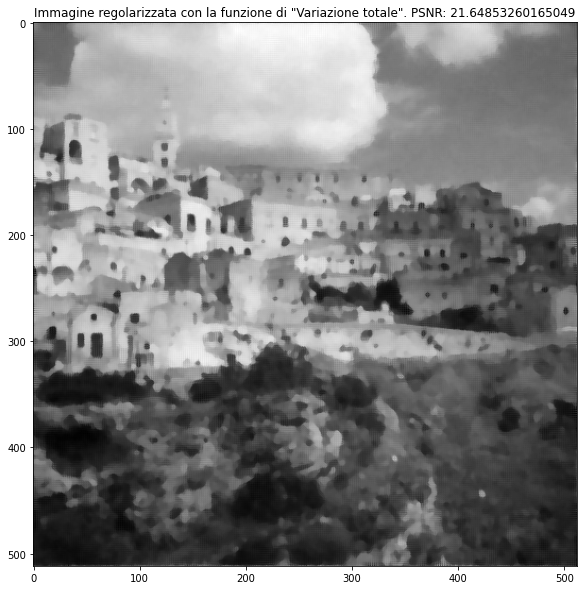

In [16]:
# Funzioni da minimizzare con Variazione Totale
def f_totvar(x):
  X = x.reshape(512, 512)
  res = 0.5 * (np.linalg.norm(A(X, K1) - noised)) ** 2 + (lambda_value * totvar(X))
  return res

def df_totvar(x):
  X = x.reshape(512, 512)
  res = AT(A(X, K1) - noised, K1) + (lambda_value * grad_totvar(X))
  res2 = np.reshape(res, 512 * 512)
  return res2


# Procedura di backtracking per la scelta della dimensione del passo specifica per il nuovo termine di regolarizzazione
def next_step_totvar(x, grad, f_totvar):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  p = -grad
  j = 0
  jmax = 10
  while ((f_totvar(x.reshape(x.size) + alpha * p) > f_totvar(x) + c1 * alpha * grad.T@p) and j < jmax):
    alpha = rho * alpha
    j += 1
  if (j > jmax):
    return -1
  else:
    return alpha


# Funzione che implementa il metodo del gradiente come visto a lezione specifica per il nuovo termine di regolarizzazione
def totvar_minimize(x0, b, MAXITERATION, ABSOLUTE_STOP, f_totvar, df_totvar):

    norm_grad_list = np.zeros((1, MAXITERATION))
    function_eval_list = np.zeros((1, MAXITERATION))
    error_list = np.zeros((1, MAXITERATION))

    # Inizializzazione
    x_last = np.copy(x0)

    k = 0

    function_eval_list[k] = f_totvar(x_last)
    error_list[k] = np.linalg.norm(x_last - b)
    norm_grad_list[k] = np.linalg.norm(df_totvar(x_last))

    while (np.linalg.norm(df_totvar(x_last)) > ABSOLUTE_STOP and k < MAXITERATION - 1):
        k = k + 1
        grad = df_totvar(x_last)

        # backtracking step
        step = next_step_totvar(x_last, grad, f_totvar)


        if (step == -1):
            print('non convergente')
            return (k)  # nessuna convergenza

        x_last = x_last - (step * grad).reshape(512, 512)

        function_eval_list[0][k] = f_totvar(x_last)
        error_list[0][k] = np.linalg.norm(x_last - b)
        norm_grad_list[0][k] = np.linalg.norm(df_totvar(x_last))

    function_eval_list = function_eval_list[0][:k + 1]
    error_list = error_list[0][:k + 1]
    norm_grad_list = norm_grad_list[0][:k + 1]

    return (x_last, norm_grad_list, function_eval_list, error_list, k)

# Ricostruzione dell'immagine utilizzando il metodo del gradiente implementato a lezione e come termine di regolarizzazione la funzione di "Variazione Totale"
(img_totvar, norm_g_list_totvar, fun_eval_list_totvar, errors_totvar, iterations_totvar) = totvar_minimize(x0, noised, 100, 1.e-5, f_totvar, df_totvar)

PSNR_totvar = metrics.peak_signal_noise_ratio(img, img_totvar)


#Plotting of the images
plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_totvar, cmap='gray')
plt.title('Immagine regolarizzata con la funzione di "Variazione totale". PSNR: ' + str(PSNR_totvar))


# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

